# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You are supposed to train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be automated testing on unseen test data. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook. 

Also don't forget to **enable GPU** before your training.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

num of files in train/:5000


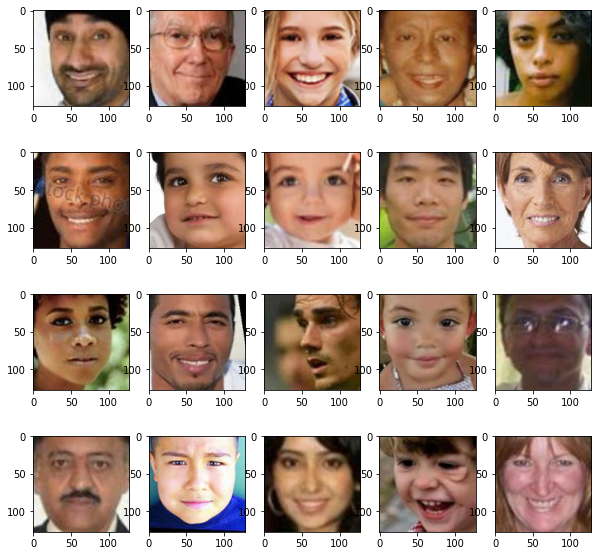

In [ ]:
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread

#shared drive must be added as shortcut from: https://drive.google.com/drive/folders/1UjYRDyo10Fx-Rv91CQl5ZfwF85HiLUX8?usp=sharing
path = '/content/drive/MyDrive/Colab Notebooks/age_gender/'
folder = '/content/drive/MyDrive/Colab Notebooks/age_gender/train_val/'
if not os.path.exists(path):
    os.mkdir(path)
if not os.path.exists(folder):
    os.mkdir(folder)


#check number of files
os.chdir('/content/drive/MyDrive/Colab Notebooks/age_gender')
num_files = len([f for f in os.listdir(folder)if os.path.isfile(os.path.join(folder, f))])
print("num of files in train/:%d" % (num_files))


#display 20 images to check dataset
os.chdir(folder)
files = os.listdir(folder)
plt.figure(figsize=(10,10))
for i in range(20): 
    plt.subplot(4,5,i+1)
    filename = files[i]
    if not os.path.exists(filename):
      print ('No such file:'+filename)
    image = imread(filename)
    plt.imshow(image)

## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


                                   names  ages  genders
0  40_0_3_20170119183403621.jpg.chip.jpg  40.0      0.0
1  75_0_0_20170117174511134.jpg.chip.jpg  75.0      0.0
2  18_1_0_20170109213011914.jpg.chip.jpg  18.0      1.0
3  70_1_3_20170116224931319.jpg.chip.jpg  70.0      1.0
4  26_1_1_20170116232602440.jpg.chip.jpg  26.0      1.0 

(128, 128, 3) 



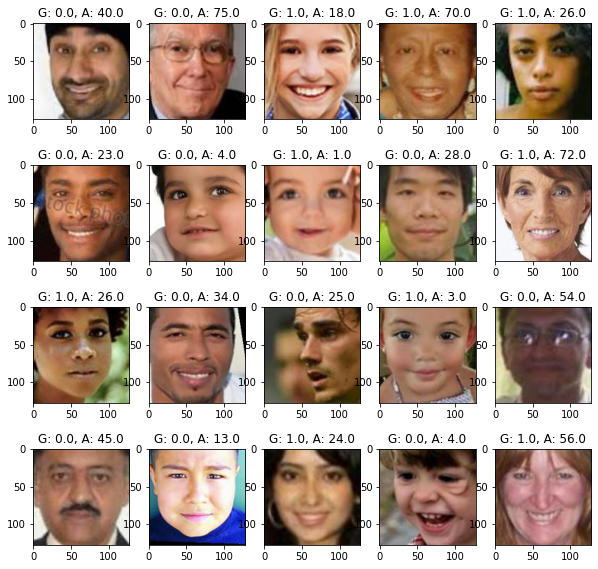

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2


#initialise some empty arrays
images = []
ages = []
genders = []
names = []


#read images and append into array
#split file data and append into corresponding arrays
for file in files:
    image = cv2.imread(folder+file,7)
    names.append(file)
    images.append(image)
    age = file.split('_')[0]
    gender = file.split('_')[1]
    ages.append(age)
    genders.append(gender)


#convert data into numpy arrays and change data from strings to floats for modelling
ages = np.array(ages, dtype=np.float32)
images = np.array(images)
images = images/255.0
genders = np.array(genders, dtype=np.float32)


#create dictionary for Pandas DataFrame
dict_labels = {
    'names': names,
    'ages': ages,
    'genders': genders

}


#create DataFrame and display the first 5 rows
df = pd.DataFrame(dict_labels)
print(df.head(), '\n')


#display images again and check the data and shape is correct.
print(images[0].shape, '\n')
plt.figure(figsize=(10,10))
for i in range(20): 
    plt.subplot(4,5,i+1)
    filename = files[i]
    if not os.path.exists(filename):
      print ('No such file:'+filename)
    image = imread(filename)
    label = "G: " + str(genders[i]) + ", A: " + str(ages[i])
    plt.title(label)
    plt.imshow(image)

## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way. 
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage. 

In [ ]:
from keras.preprocessing.image import ImageDataGenerator


#data augmentation to improve our model. Option settings used from Chollet, F. (2018) Deep Learning with Python.
#0.2 (20%) of the data is left for validation.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
    validation_split = 0.2
    )


#validation data is not augmented
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split = 0.2
    )

#default batch size provided best results
batch_size = 32


#flow from dataframe is used to create batches of augmented images
train_generator = train_datagen.flow_from_dataframe(
    dataframe = df,
    directory = folder,
    x_col = 'names',
    y_col = ['ages', 'genders'],
    target_size = (128, 128),
    batch_size=batch_size,
    class_mode = 'raw',
    shuffle = True,
    subset = 'training')

val_generator = val_datagen.flow_from_dataframe(
    dataframe = df,
    directory = folder,
    x_col = 'names',
    y_col = ['ages', 'genders'],
    target_size = (128, 128),
    batch_size=batch_size,
    class_mode = 'raw',
    shuffle = True,
    subset = 'validation')


Found 4000 validated image filenames.
Found 1000 validated image filenames.


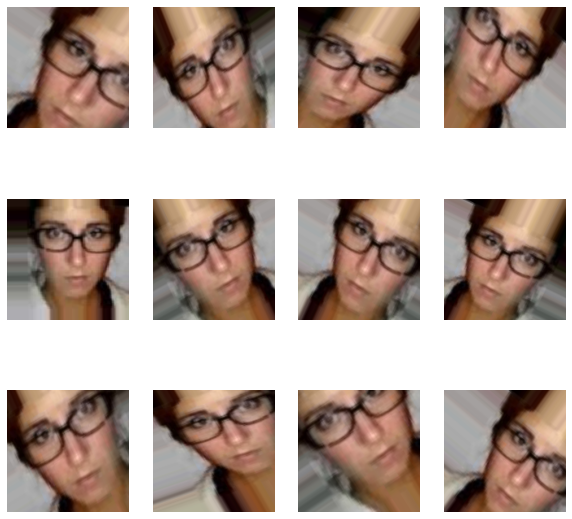

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt


#check how an image looks when augmented
fnames = [os.path.join(folder,fname) for fname in os.listdir(folder)]
img_path = fnames[111]
img = image.load_img(img_path, target_size=(150,150))
x = image.img_to_array(img)
x = x.reshape((1,)+x.shape)
i = 0
plt.figure(figsize=(10,10))
for batch in train_datagen.flow(x,batch_size=1):
  plt.subplot(3,4,i+1)
  plt.axis("off")
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i%12 == 0:
    break
plt.show()

## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
3.	You may choose any techniques for preventing overfitting. 

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

In [ ]:
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers, regularizers


#create convolutional layers to learn local patterns
inputs = Input(shape=(128,128,3), batch_size = batch_size)
conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu', padding = 'same')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu', padding = 'same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu', padding = 'same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, kernel_size=(3, 3),activation='relu', padding = 'same')(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(512, kernel_size=(3, 3),activation='relu', padding = 'same')(pool4)
pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
conv6 = Conv2D(1024, kernel_size=(3, 3),activation='relu', padding = 'same')(pool5)
pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)
conv7 = Conv2D(2048, kernel_size=(3, 3),activation='relu', padding = 'same')(pool6)
pool8 = MaxPooling2D(pool_size=(2, 2))(conv7)

#set dropout size, used to prevent overfitting
dropout = Dropout(0.5)


#flatten the 3D output to 1D for our dense layer
age_drop = dropout(pool8)
age_flat = Flatten()(age_drop)
age_model = dropout(age_flat)
age_model = Dense(2048, activation='relu',  kernel_regularizer=regularizers.l2(0.001))(age_model)
age_model = dropout(age_model)
age_model = Dense(1, activation='relu', name = 'age')(age_model)


#flatten the 3D output to 1D from pool4 (better results)
gender_flat = Flatten()(pool4)
gender_model = Dense(2048, activation='relu')(gender_flat)
gender_model = dropout(gender_model)
gender_model = Dense(1, activation='sigmoid', name = 'gender')(gender_model)


#build model with 1 input, 2 outputs
modelA = Model(inputs=inputs, outputs=[age_model,gender_model])
modelA.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(32, 128, 128, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (32, 128, 128, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (32, 64, 64, 32)     0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (32, 64, 64, 64)     18496       ['max_pooling2d[0][0]']          
                                                                                              

## STEP3A: Compile and train your model
Compile and train your model here. 
Save your model by `modelA.save_model(your_model_folder+"age_gender_A.h5")` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by `modelA.load_model(model_folder+"age_gender_A.h5")`. 


In [ ]:
#this extra function is required as we have two outputs, code from Vijayabhaskar, J. (2019) Multi-label image classification Tutorial with Keras ImageDataGenerator.
def generator_wrapper(generator):
    for batch_x,batch_y in generator:
        yield (batch_x,[batch_y[:,i] for i in range(2)])

In [ ]:
import keras


#compile the model with an optimiser, and corresponding loss functions and metrics
modelA.compile(optimizer = 'adam', 
              loss = {
                  'age': 'mean_squared_error',
                  'gender': 'binary_crossentropy'
              }, 
              metrics = {
                  'age': 'mae',
                  'gender': 'accuracy'
              }
             )


#calculate step sizes
step_size_train=train_generator.n//train_generator.batch_size
step_size_val=val_generator.n//val_generator.batch_size


#start training using fit_generator as we are using an image generator, 240 epochs = 2 hours with GPU 
history = modelA.fit_generator(
      generator_wrapper(train_generator),
      steps_per_epoch=step_size_train,
      validation_data=generator_wrapper(val_generator),
      validation_steps=step_size_val,
      epochs=250
)


#save model
model_folder = '/content/drive/MyDrive/Colab Notebooks/models'
import os
if not os.path.exists(model_folder):
    os.mkdir(model_folder)
modelA.save(model_folder+'/age_gender_A.h5') 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/250
125/125 [==============================] - 34s 196ms/step - loss: 859.2653 - age_loss: 857.0651 - gender_loss: 0.7741 - age_mae: 20.4346 - gender_accuracy: 0.5100 - val_loss: 401.7539 - val_age_loss: 399.7830 - val_gender_loss: 0.6969 - val_age_mae: 15.1434 - val_gender_accuracy: 0.4698
Epoch 2/250
125/125 [==============================] - 25s 199ms/step - loss: 435.0673 - age_loss: 433.1581 - gender_loss: 0.6903 - age_mae: 15.9932 - gender_accuracy: 0.5343 - val_loss: 470.5118 - val_age_loss: 468.6527 - val_gender_loss: 0.6832 - val_age_mae: 16.0422 - val_gender_accuracy: 0.5373
Epoch 3/250
125/125 [==============================] - 25s 199ms/step - loss: 424.6306 - age_loss: 422.7957 - gender_loss: 0.6844 - age_mae: 15.7755 - gender_accuracy: 0.5483 - val_loss: 380.1464 - val_age_loss: 378.3538 - val_gender_loss: 0.6643 - val_age_mae: 14.8240 - val_gender_accuracy: 0.6250
Epoch 4/250
125/125 [==============================] - 24s 192ms/step - loss: 427.3150 - age_loss: 4

## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


Text(0.5, 0, 'epoch')

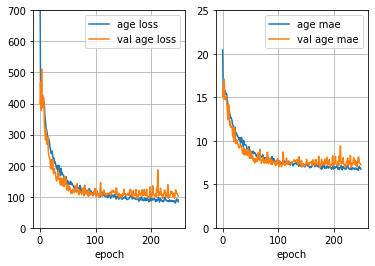

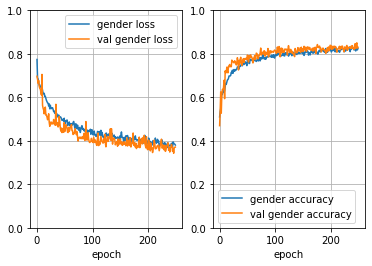

In [ ]:
#plot age loss and error
import matplotlib.pyplot as plt
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.plot(history.history['age_loss'], label='age loss')
plt.plot(history.history['val_age_loss'], label='val age loss')
plt.legend()
plt.grid(True)
plt.ylim([0,700])
plt.xlabel('epoch')

fig.add_subplot(1,2,2)
plt.plot(history.history['age_mae'], label='age mae')
plt.plot(history.history['val_age_mae'], label='val age mae')
plt.legend()
plt.grid(True)
plt.ylim([0,25])
plt.xlabel('epoch')

#plot gender loss and accuracy
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.plot(history.history['gender_loss'], label='gender loss')
plt.plot(history.history['val_gender_loss'], label='val gender loss')
plt.legend()
plt.grid(True)
plt.ylim([0,1.0])
plt.xlabel('epoch')

fig.add_subplot(1,2,2)
plt.plot(history.history['gender_accuracy'], label='gender accuracy')
plt.plot(history.history['val_gender_accuracy'], label='val gender accuracy')
plt.legend()
plt.grid(True)
plt.ylim([0,1.0])
plt.xlabel('epoch')

## STEP2B: Build a CNN network based on a pre-trained model 
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


In [ ]:
from keras.applications.vgg16 import VGG16
#from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
#from tensorflow.keras.applications.inception_v3 import InceptionV3

#set input
inputB = Input(shape=(128,128,3), batch_size = batch_size)

#build model base from VGG16 using weights loaded from imagenet. include_top set to false as we do not want the classifier.
model_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_tensor = inputB)


#fine tune network by setting block of conv layers as trainable
model_base.trainable = True
set_trainable = False
for layer in model_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

#flatten output of model_base for FC layers
flat = Flatten()(model_base.output)


#age dense network
age_model_B = dropout(flat)
age_model_B = Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.001))(age_model_B)
age_model_B = dropout(age_model_B)
age_model_B = Dense(1, activation='relu', name = 'age')(age_model_B)


#gender dense network
gender_model_B = dropout(flat)
gender_model_B = Dense(2048, activation='relu')(gender_model_B)
gender_model_B = dropout(gender_model_B)
gender_model_B = Dense(1, activation='sigmoid', name = 'gender')(gender_model_B)

#set model and look at summary
modelB = Model(inputs=model_base.input, outputs=[age_model_B,gender_model_B])
modelB.summary()


58900480/58889256 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(32, 128, 128, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (32, 128, 128, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 block1_conv2 (Conv2D)          (32, 128, 128, 64)   36928       ['block1_conv1[0][0]']           
                                                                                                  
 block1_pool (MaxPooling2D)     (32, 64, 64, 64)     0           ['block1_conv2[0][0]']           
                           

## STEP3B: Compile and train your model
Compile and train your model here. 
Save your model to `age_gender_B.h5` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.** 


In [ ]:
from tensorflow.keras.optimizers import SGD, RMSprop

#compile model with low learning rate to effectively train conv layers
modelB.compile(optimizer = RMSprop(lr=1e-4),
              loss = {
                  'age': 'mean_squared_error',
                  'gender': 'binary_crossentropy'
              }, 
              metrics = {
                  'age': 'mae',
                  'gender': 'accuracy'
              }
             )

historyB = modelB.fit_generator(
      generator_wrapper(train_generator),
      steps_per_epoch=step_size_train,
      validation_data=generator_wrapper(val_generator),
      validation_steps=step_size_val,
      epochs=250
)


model_folder = '/content/drive/MyDrive/Colab Notebooks/models'
import os
if not os.path.exists(model_folder):
    os.mkdir(model_folder)
modelB.save(model_folder+'/age_gender_B.h5') 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/250
125/125 [==============================] - 30s 219ms/step - loss: 355.8393 - age_loss: 352.0025 - gender_loss: 1.0584 - age_mae: 14.0832 - gender_accuracy: 0.5918 - val_loss: 186.2687 - val_age_loss: 183.1212 - val_gender_loss: 0.5718 - val_age_mae: 10.1251 - val_gender_accuracy: 0.6825
Epoch 2/250
125/125 [==============================] - 25s 203ms/step - loss: 206.5808 - age_loss: 203.4517 - gender_loss: 0.6982 - age_mae: 10.5140 - gender_accuracy: 0.6455 - val_loss: 512.9261 - val_age_loss: 510.1151 - val_gender_loss: 0.5233 - val_age_mae: 18.1886 - val_gender_accuracy: 0.7581
Epoch 3/250
125/125 [==============================] - 25s 201ms/step - loss: 186.2635 - age_loss: 183.4063 - gender_loss: 0.6787 - age_mae: 9.8825 - gender_accuracy: 0.6575 - val_loss: 144.7845 - val_age_loss: 142.1505 - val_gender_loss: 0.5570 - val_age_mae: 8.8738 - val_gender_accuracy: 0.7349
Epoch 4/250
125/125 [==============================] - 25s 201ms/step - loss: 166.2414 - age_loss: 163

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

Text(0.5, 0, 'epoch')

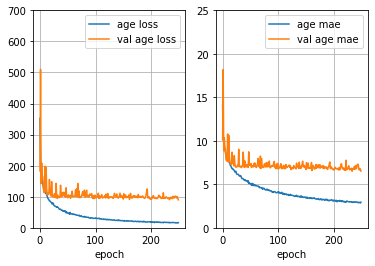

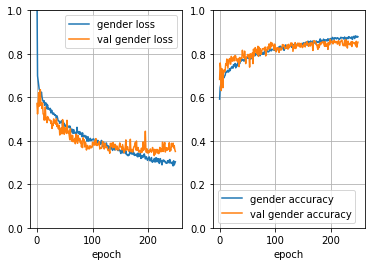

In [ ]:
#plot model
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.plot(historyB.history['age_loss'], label='age loss')
plt.plot(historyB.history['val_age_loss'], label='val age loss')
plt.legend()
plt.grid(True)
plt.ylim([0,700])
plt.xlabel('epoch')

fig.add_subplot(1,2,2)
plt.plot(historyB.history['age_mae'], label='age mae')
plt.plot(historyB.history['val_age_mae'], label='val age mae')
plt.legend()
plt.grid(True)
plt.ylim([0,25])
plt.xlabel('epoch')

fig = plt.figure()
fig.add_subplot(1,2,1)
plt.plot(historyB.history['gender_loss'], label='gender loss')
plt.plot(historyB.history['val_gender_loss'], label='val gender loss')
plt.legend()
plt.grid(True)
plt.ylim([0,1.0])
plt.xlabel('epoch')

fig.add_subplot(1,2,2)
plt.plot(historyB.history['gender_accuracy'], label='gender accuracy')
plt.plot(historyB.history['val_gender_accuracy'], label='val gender accuracy')
plt.legend()
plt.grid(True)
plt.ylim([0,1.0])
plt.xlabel('epoch')

## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission. 

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#